# Gradient Descent "By Hand"

---

Prof. Dr.-Ing. Antje Muntzinger, Hochschule für Technik Stuttgart

antje.muntzinger@hft-stuttgart.de

---

In this notebook, we implement gradient descent from scratch. The idea is to calculate the different steps with pen and paper for comparison, at least the first iteration. This will help understand the algorithm steps in more depth.

Our task is to fit a line through 3 example data points. This regression problem can be thought of as a tiny neural net with just one neuron: an input $x_1$ weighted by $\theta_1$, a bias $\theta_0$ and a predicted output $\hat y$.

In [15]:
from IPython.display import Image
Image(url="./images/neuron.png", width=500)

In [1]:
# imports
import numpy as np 
import matplotlib.pyplot as plt

As fictional application, we want to predict median house prices in an area based on median income in this region. We have 3 data points as training data:

In [2]:
# 3 data points to be fitted by a regression line (stored as 2D array for matrix calculations)
x = np.array([[100], [70], [140]]) # income (in 1000)
y = np.array([[300], [200], [500]]) # house price (in 1000)

# we add a constant value 1 for the bias term (to be multiplied with theta0)
x_with_bias = np.concatenate((np.ones((len(x),1)), x), axis=1)
print('x_with_bias =', x_with_bias)
print('y =', y)

x_with_bias = [[  1. 100.]
 [  1.  70.]
 [  1. 140.]]
y = [[300]
 [200]
 [500]]


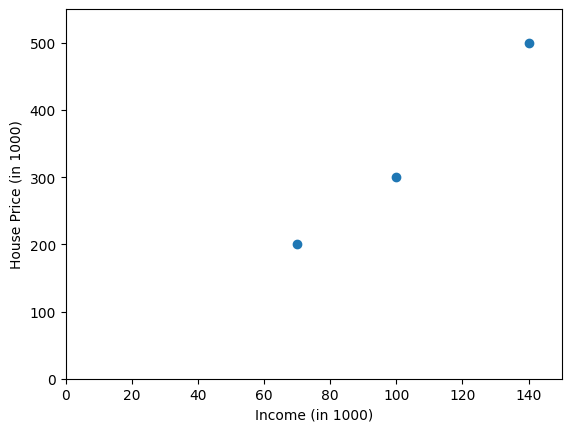

In [3]:
# plot data
def plot_points():
    plt.scatter(x,y)
    plt.axis([0, 150, 0, 550])
    plt.xlabel("Income (in 1000)") # fictional application: predict median house prices in an area based on median income of inhabitants
    plt.ylabel("House Price (in 1000)")

plot_points()

In [4]:
# init params
theta_init = np.array([[70], [1]]) # manual selection of some start value
# theta_init = np.random.randn(2,1) # alternative: random start value (mean 0, standard deviation 1)
print('theta_init=', theta_init)

eta = 0.00005 # learning rate. Note that for higher learning rate, we get exploding gradients, so we should use regularization (omitted here to keep it simple).
m = len(y) # number of samples = 3
n_iter = 1000000 # number of iterations
print_every = 50000 # output current values every ... iterations
eps = 0.1 # stop if gradient norm falls below this value -> minimum accepted as solution

theta_init= [[70]
 [ 1]]


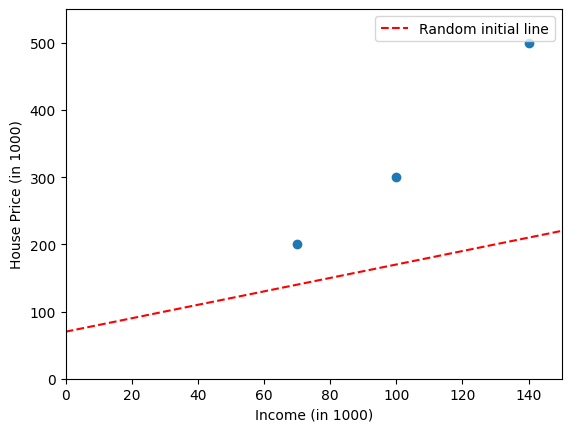

In [5]:
# plot initial line (if not visible, it lies outside the selected plot range)
x_points = np.linspace(0, 150, 500).reshape(-1, 1)

def plot_init_data():
    plot_points()
    plt.plot(x_points, theta_init[0] + theta_init[1]*x_points, color='r', linestyle='--', label='Random initial line')
    plt.legend()

plot_init_data()

We see that the loss (error) of the red initial line is quite high, the blue points are not well approximated. To quantify this loss, we calculate the mean square error (MSE) - for initial $\theta = (70, 1)^T$, the MSE is the following:

$\text{MSE}(\theta)=\frac 1m\sum_{i=1}^m\left(\theta^T x^{(i)}-y^{(i)}\right)^2$

$=\frac 13\left[ \left( \begin{pmatrix}70 & 1\end{pmatrix} \begin{pmatrix}1\\100\end{pmatrix} - 300 \right)^2 + \left( \begin{pmatrix}70 & 1\end{pmatrix} \begin{pmatrix}1\\70\end{pmatrix} - 200 \right)^2 + \left( \begin{pmatrix}70 & 1\end{pmatrix} \begin{pmatrix}1\\140\end{pmatrix} - 500 \right)^2 \right]$

$=\frac 13\left[ \left( -130 \right)^2 + \left( -60 \right)^2 + \left( -290\right)^2 \right] = 34867$

(Note that the result for random start values of $\theta$ will be different.)

In [6]:
# calc mean square error with current parameters theta (written componentwise for better understanding)
theta = theta_init
MSE = 1/m*( (x_with_bias[0] @ theta - y[0])**2 + (x_with_bias[1] @ theta - y[1])**2 + (x_with_bias[2] @ theta - y[2])**2 )
print('MSE=', MSE)

MSE= [34866.66666667]


We can think of this loss function (error function) as a 3D "mountain" $\mathcal L(\theta_0, \theta_1)$. The exact position in the mountain depends on the parameters $\theta_0$ and $\theta_1$, so we want to find parameters that make the loss minimal (like a "valley" in our "mountain"). This is the idea of gradient descent: We start with a random starting position in the "mountain" (random initial $\theta$) and try to achieve a smaller error by adapting our parameters $\theta$, taking a step in the "downward" direction of the error. The gradient always points in the direction of steepest increase, so we use the negative gradient direction to decrease our error. We can steer the step size by choosing the learning rate $\eta$.

In [16]:
from IPython.display import Image
Image(url="./images/GD.png", width=700)

To calculate the gradient, we need the partial derivatives with respect to our weights $\theta$ that we want to adapt. The first partial derivative for $\theta = (70, 1)^T$ is (using the chain rule)*:

$\frac{\partial}{\partial \theta_0}\text{MSE}(\theta)=\frac 2m\sum_{i=1}^m\left(\theta^T x^{(i)}-y^{(i)}\right)x_0^{(i)}=\frac 23\left[ \left( -130 \right)\cdot 1 + \left( -60 \right)\cdot 1 + \left( -290\right)\cdot 1 \right] = -320
$

In [7]:
# calc first partial derivatives of MSE with respect to parameters theta (written componentwise for better understanding)
partial0_MSE = 2/m*( (x_with_bias[0] @ theta - y[0]) * x_with_bias[0][0]  + (x_with_bias[1] @ theta - y[1]) * x_with_bias[1][0] + (x_with_bias[2] @ theta - y[2]) * x_with_bias[2][0] )
print('partial0_MSE=', partial0_MSE)

partial0_MSE= [-320.]


And the second partial derivative for $\theta = (70, 1)^T$ is:

$\frac{\partial}{\partial \theta_1}\text{MSE}(\theta)=\frac 2m\sum_{i=1}^m\left(\theta^T x^{(i)}-y^{(i)}\right)x_1^{(i)}=\frac 23\left[ \left( -130 \right)\cdot 100 + \left( -60 \right)\cdot 70 + \left( -290\right)\cdot 140 \right] = -38533
$

In [8]:
# calc second partial derivative of MSE with respect to parameters theta (written componentwise for better understanding)
partial1_MSE = 2/m*( (x_with_bias[0] @ theta - y[0]) * x_with_bias[0][1]  + (x_with_bias[1] @ theta - y[1]) * x_with_bias[1][1] + (x_with_bias[2] @ theta - y[2]) * x_with_bias[2][1] )
print('partial1_MSE=', partial1_MSE)

partial1_MSE= [-38533.33333333]


This gives the full gradient $\nabla_{\theta}\text{MSE}(\theta) = \begin{pmatrix}-320\\-38533\end{pmatrix}$

In [9]:
# the gradient is just a vector containing these partial derivatives
gradient_MSE = np.array([partial0_MSE, partial1_MSE])
print('gradient_MSE=', gradient_MSE)

gradient_MSE= [[  -320.        ]
 [-38533.33333333]]


With this, we can finally do the first gradient descent step and update the parameters:

$\theta^{(new)}=\theta^{(old)}-\eta\cdot\nabla_{\theta}\text{MSE}(\theta)=\begin{pmatrix}70\\1\end{pmatrix} - 0.00005\cdot\begin{pmatrix}-320\\-38533\end{pmatrix} = \begin{pmatrix}70.016\\2.9267\end{pmatrix}$


In [10]:
# update parameters theta = one gradient descent step
theta = theta - eta * gradient_MSE
print('theta=', theta)

theta= [[70.016     ]
 [ 2.92666667]]


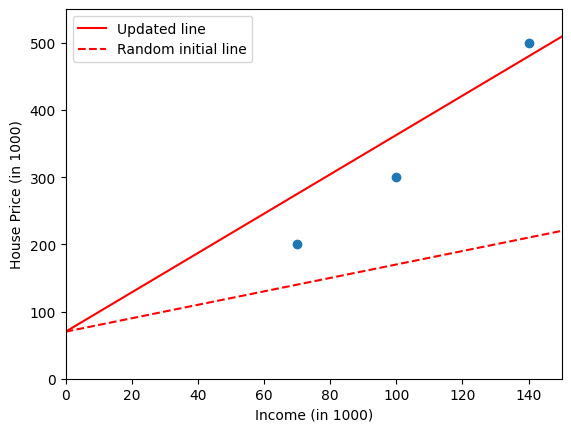

In [11]:
# plot initial and updated line
plt.plot(x_points, theta[0] + theta[1]*x_points, color='r', label='Updated line')
plot_init_data()

The updated line looks a little bit better than the initial line! Now we repeat many more gradient descent steps to adapt the weights successively and improve our model:

iter= 0 MSE= [3315.53998933] gradient_MSE= [[  78.20977778]
 [5783.30666667]] theta= [[70.01208951]
 [ 2.63750133]]
iter= 50000 MSE= [1358.34594428] gradient_MSE= [[18.35455317]
 [-0.164926  ]] theta= [[14.85378729]
 [ 3.17087184]]
iter= 100000 MSE= [756.57529703] gradient_MSE= [[12.83810027]
 [-0.11535756]] theta= [[-23.7269486 ]
 [  3.51754148]]
iter= 150000 MSE= [462.1704916] gradient_MSE= [[ 8.97961487]
 [-0.0806869 ]] theta= [[-50.71226126]
 [  3.76001971]]
iter= 200000 MSE= [318.13855875] gradient_MSE= [[ 6.28079557]
 [-0.05643648]] theta= [[-69.58715005]
 [  3.92962121]]
iter= 250000 MSE= [247.6736842] gradient_MSE= [[ 4.39310522]
 [-0.03947452]] theta= [[-82.7891993 ]
 [  4.04824906]]
iter= 300000 MSE= [213.20008903] gradient_MSE= [[ 3.07275937]
 [-0.02761047]] theta= [[-92.02337845]
 [  4.13122336]]
iter= 350000 MSE= [196.33454046] gradient_MSE= [[ 2.14924289]
 [-0.01931216]] theta= [[-98.4822291 ]
 [  4.18925977]]
iter= 400000 MSE= [188.08339267] gradient_MSE= [[ 1.50328888]


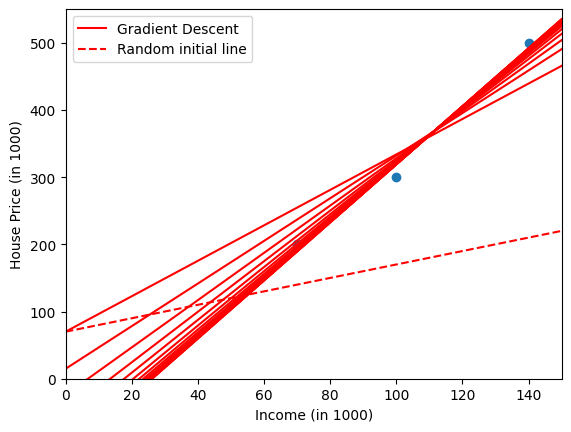

In [12]:
# let's make a loop to repeat these steps over and over:

for iter in range(n_iter):
    # calc mean square error with current parameters theta
    MSE = 1/m*( (x_with_bias[0] @ theta - y[0])**2 + (x_with_bias[1] @ theta - y[1])**2 + (x_with_bias[2] @ theta - y[2])**2 )
    
    # calc partial derivatives of MSE with respect to parameters theta
    partial0_MSE = 2/m*( (x_with_bias[0] @ theta - y[0]) * x_with_bias[0][0]  + (x_with_bias[1] @ theta - y[1]) * x_with_bias[1][0] + (x_with_bias[2] @ theta - y[2]) * x_with_bias[2][0] )
    partial1_MSE = 2/m*( (x_with_bias[0] @ theta - y[0]) * x_with_bias[0][1]  + (x_with_bias[1] @ theta - y[1]) * x_with_bias[1][1] + (x_with_bias[2] @ theta - y[2]) * x_with_bias[2][1] )
    
    # the gradient is just a vector containing these partial derivatives
    gradient_MSE = np.array([partial0_MSE, partial1_MSE])
    
    # update parameters theta = one gradient descent step
    theta = theta - eta * gradient_MSE

    # print and plot some info and check for conversion
    if iter % print_every == 0:
        print('iter=', iter, 'MSE=', MSE, 'gradient_MSE=', gradient_MSE, 'theta=', theta) 
        plt.plot(x_points, theta[0] + theta[1]*x_points, color='r', label="Gradient Descent" if iter == 0 else "")
        
        if np.linalg.norm(gradient_MSE) < eps:
            print('Minimum reached!! Breaking...')
            break

plot_init_data()

We see that the line converges to a solution running nearly through the blue points, we have found our optimal parameters!

Alternatively, we can directly calculate the optimal solution $\hat \theta = \left( X^TX \right)^{-1}X^T y$ using the normal equation. This is computationally expensive, so we use gradient descent in practice, but for comparison, here is the direct solution:

$\hat \theta = \left( X^TX \right)^{-1}X^T y = \left( \begin{pmatrix}1 & 1 & 1\\ 100 & 70 & 140\end{pmatrix}\begin{pmatrix}1 & 100 \\ 1 & 70 \\ 1 & 140\end{pmatrix} \right)^{-1}
\begin{pmatrix}1 & 1 & 1\\ 100 & 70 & 140\end{pmatrix} \begin{pmatrix}300 \\ 200 \\ 500\end{pmatrix}$ 

$=\begin{pmatrix}3 & 310 \\ 310 & 34500\end{pmatrix}^{-1}\begin{pmatrix}1000 \\ 114000\end{pmatrix}=\begin{pmatrix}4.66216 & -0.04189 \\-0.04189 & 0.0004\end{pmatrix}\begin{pmatrix}1000 \\ 114000\end{pmatrix}
\approx \begin{pmatrix}-113 \\ 4\end{pmatrix}$ 

This gives the optimal regression line $y=4x-113$.

theta_hat (direct solution) = [[-113.51351351]
 [   4.32432432]]
theta (gradient descent) = [[-112.9112194 ]
 [   4.31891237]]


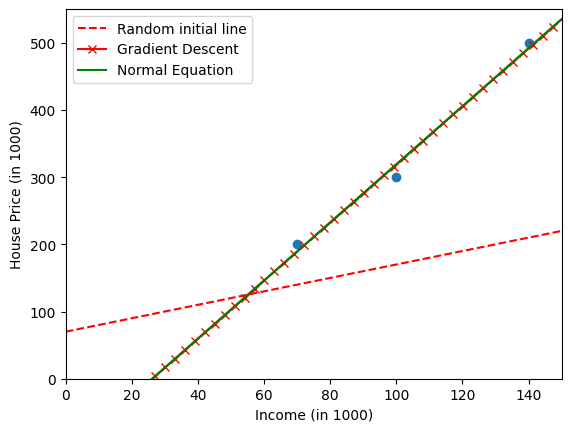

In [13]:
theta_hat = np.linalg.inv(x_with_bias.T @ x_with_bias) @ x_with_bias.T @ y
print('theta_hat (direct solution) =', theta_hat)
print('theta (gradient descent) =', theta)

plot_init_data()
plt.plot(x_points, theta[0] + theta[1]*x_points, color='r', marker='x', markevery=10, label = 'Gradient Descent')
plt.plot(x_points, theta_hat[0] + theta_hat[1]*x_points, color='g', label = 'Normal Equation')
plt.legend()

We see that Gradient Descent has found the optimal solution iteratively, the line is identical to the direct solution using normal equation. Both fit the 3 data points very well.

---
*Here is the detailed explanation for the derivatives: We want to calculate the partial derivatives of $\text{MSE}(\theta)=\frac 1m\sum_{i=1}^m\left(\theta^T x^{(i)}-y^{(i)}\right)^2$ with respect to $\theta_k$, so let's only look at a single summand and write it as two functions $f$ and $g$ (we ignore the superscript $^{(i)}$ indicating the number of the sample for a moment):

$f(g(\theta))=\left(\theta^T x-y\right)^2$, where

- $f(z)=z^2$ with derivative $\frac{\partial}{\partial z}f(z)=\color{green}2\color{black}z$ and
- $g(\theta)=g(\theta, x, y) = \theta^T x-y =\theta_0 x_0+\theta_1 x_1-y$ with partial derivatives 
    - $\frac{\partial}{\partial \theta_0}g(\theta) 
    = \frac{\partial}{\partial \theta_0}(\underbrace{\theta_0 x_0}_{\frac{\partial}{\partial \theta_0}=\color{red}1\cdot x_0}+\underbrace{\theta_1 x_1}_{\frac{\partial}{\partial \theta_0}=0}-\underbrace{y}_{\frac{\partial}{\partial \theta_0}=0})=\color{red}x_0$ and
    - $\frac{\partial}{\partial \theta_1}g(\theta) 
    = \frac{\partial}{\partial \theta_1}(\underbrace{\theta_0 x_0}_{\frac{\partial}{\partial \theta_1}=0}+\underbrace{\theta_1 x_1}_{\frac{\partial}{\partial \theta_1}=\color{red}1\cdot x_1}-\underbrace{y}_{\frac{\partial}{\partial \theta_1}=0})=\color{red}x_1$, in general:
    - $\frac{\partial}{\partial \theta_k}g(\theta) = \frac{\partial}{\partial \theta_k}\left(\theta^T x-y \right) = \color{red}x_k$.

Using the chain rule (https://en.wikipedia.org/wiki/Chain_rule), we know that $\frac{\partial f}{\partial \theta_k}=\frac{\partial f}{\partial g}\cdot \frac{\partial g}{\partial \theta_k}$, or in more detail:

$\frac{\partial}{\partial \theta_k}(f(g(\theta))=\frac{\partial}{\partial g}f(g(\theta))\cdot \frac{\partial}{\partial \theta_k}g(\theta)
=\color{green}2\color{black}g(\theta)\cdot \color{red}x_k \color{black}
=\color{green}2\color{black}\left(\theta^T x-y\right)\cdot \color{red}x_k. $

Putting it all together:

$\frac{\partial}{\partial \theta_k}\text{MSE}(\theta)
=\frac{\partial}{\partial \theta_k}\left(\frac 1m\sum_{i=1}^m\left(\theta^T x^{(i)}-y^{(i)}\right)^2\right)
=\frac{\partial}{\partial \theta_k}\left(\frac 1m\sum_{i=1}^m f(g(\theta, x^{(i)}, y^{(i)}))\right)
=\frac 1m\sum_{i=1}^m \underbrace{\frac{\partial}{\partial \theta_k}\left(f(g(\theta, x^{(i)}, y^{(i)}))\right)}_{=\color{green}2\color{black}\left(\theta^T x^{(i)}-y^{(i)}\right)\cdot \color{red}x_k^{(i)}}
=\frac {\color{green}2}{\color{black}m}\sum_{i=1}^m\left(\theta^T x^{(i)}-y^{(i)}\right)\color{red}x_k^{(i)}$.